# Clinical Trials by Volume of Publications

This notebook shows how use the [Dimensions Analytics API](https://www.dimensions.ai/dimensions-apis/) in order to get a list of clinical trials records and then sort them by the total number of publications they cite.

## Prerequisites

This notebook assumes you have installed the [Dimcli](https://pypi.org/project/dimcli/) library and are familiar with the *Getting Started* tutorial.


In [1]:
!pip install dimcli plotly tqdm -U --quiet 

import dimcli
from dimcli.utils import *

import os, sys, time, json
from tqdm.notebook import tqdm 
import pandas as pd
import plotly.express as px
from plotly.offline import plot
if not 'google.colab' in sys.modules:
  # make js dependecies local / needed by html exports
  from plotly.offline import init_notebook_mode
  init_notebook_mode(connected=True)

print("==\nLogging in..")
# https://digital-science.github.io/dimcli/getting-started.html#authentication
ENDPOINT = "https://app.dimensions.ai"
if 'google.colab' in sys.modules:
  import getpass
  KEY = getpass.getpass(prompt='API Key: ')  
  dimcli.login(key=KEY, endpoint=ENDPOINT)
else:
  KEY = ""
  dimcli.login(key=KEY, endpoint=ENDPOINT)
dsl = dimcli.Dsl()

==
Logging in..
Dimcli - Dimensions API Client (v0.8.2)
Connected to: https://app.dimensions.ai - DSL v1.28
Method: dsl.ini file


## Query for Clinical Trials

In [2]:
q = """search clinical_trials where category_rcdc.name="Multiple Sclerosis" 
        and active_years=[2017, 2018, 2019] 
        return clinical_trials[basics+publication_ids]"""

In [3]:
df = dsl.query_iterative(q).as_dataframe()
df.head()

Starting iteration with limit=1000 skip=0 ...
0-1000 / 2310 (3.08s)
1000-2000 / 2310 (2.89s)
2000-2310 / 2310 (1.12s)
===
Records extracted: 2310


investigator_details  \
0  [[Jacob J Sosnoff, PhD, Principal Investigator...   
1                                                NaN   
2  [[Luisa Klotz, PD Dr med, Principal Investigat...   
3                                                NaN   
4  [[Peter Feys, prof dr, Principal Investigator,...   

               active_years  \
0              [2015, 2016]   
1              [2015, 2016]   
2        [2014, 2015, 2016]   
3  [2014, 2015, 2016, 2017]   
4        [2014, 2015, 2016]   

                                               title           id  \
0  Computerized Cognition Testing and Cognitive M...  NCT02318576   
1  A Multicenter, Open-Label, 12-Month Observatio...  NCT02323269   
2  A 32-week, Monocentric, Exploratory, Single Ar...  NCT02325440   
3  Patient Reported Outcomes With Fingolimod in L...  NCT02335892   
4  Psychometric Properties of Outcome Measures fo...  NCT02339675   

    publication_ids  
0               NaN  
1               NaN  
2  [pub.1105419585]  
3               NaN  
4               NaN

## Counting publications per clinical trial

Before we can count publications, we should ensure that all the values are 'countable'. So we have to transform all None values in `publication_ids` into empty lists first.

In [4]:
# replace empty values with empty lists so that they can be counted
for row in df.loc[df.publication_ids.isnull(), 'publication_ids'].index:
    df.at[row, 'publication_ids'] = []

Now it's ok to count publications

In [5]:
# create new column
df['pubs_tot'] = df['publication_ids'].apply(lambda x: len(x))
# sort 
df.sort_values("pubs_tot", ascending=False, inplace=True)
df.head(5)

investigator_details  \
1236                                                NaN   
1006  [[Dawn Ehde, PhD, Principal Investigator, Univ...   
82    [[Gavin Givannoni, , Principal Investigator, Q...   
805   [[Myla Goldman, MD, Principal Investigator, Un...   
2167  [[Bruce Cree, MD, PhD, MAS, Principal Investig...   

                              active_years  \
1236                    [2019, 2020, 2021]   
1006        [2018, 2019, 2020, 2021, 2022]   
82          [2014, 2015, 2016, 2017, 2018]   
805         [2016, 2017, 2018, 2019, 2020]   
2167  [2020, 2021, 2022, 2023, 2024, 2025]   

                                                  title           id  \
1236  Exploration of Brain Changes Due to a Targeted...  NCT04073940   
1006  Mindfulness-based Cognitive Therapy and Cognit...  NCT03782246   
82    OxCarbazepine as a Neuroprotective Agent in MS...  NCT02104661   
805   Assessment of the Clinical Importance of Insul...  NCT03004079   
2167  Impact of Ocrelizumab on Cerebrospinal Fluid B...  NCT04466150   

                                        publication_ids  pubs_tot  
1236  [pub.1083319037, pub.1009477785, pub.101592704...       100  
1006  [pub.1053925843, pub.1007565109, pub.105228507...        73  
82    [pub.1064157001, pub.1025592460, pub.101978498...        48  
805   [pub.1033394944, pub.1030394891, pub.102122971...        46  
2167  [pub.1126808290, pub.1001923498, pub.105943841...        45

A simple data visualization

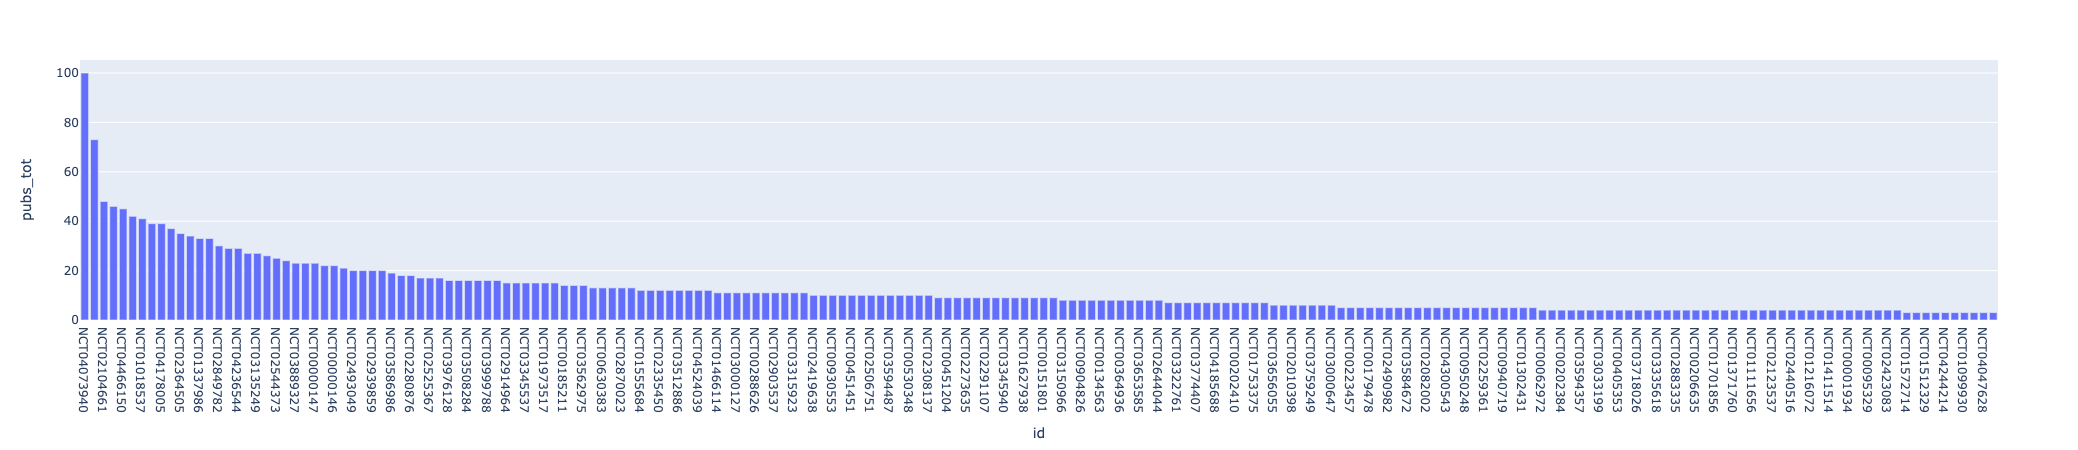

In [6]:
px.bar(df[:200], x="id", y="pubs_tot", 
      hover_name="title", hover_data=["active_years"])